<a href="https://colab.research.google.com/github/clssmitty/OpenDeliveryNetwork/blob/master/OpenPickleballLinecaller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An application to detect pickleballs landing near the boundary lines for alerting players of balls that go out to prevent disputes.

## Install the required libraries

In [ ]:
!pip install roboflow
!pip install supervision
!pip install inference

In [ ]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip show supervision
!pip show opencv-python

Name: supervision
Version: 0.25.1
Summary: A set of easy-to-use utils that will come in handy in any Computer Vision project
Home-page: https://github.com/roboflow/supervision
Author: Piotr Skalski
Author-email: piotr.skalski92@gmail.com
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: contourpy, defusedxml, matplotlib, numpy, opencv-python, pillow, pyyaml, requests, scipy, tqdm
Required-by: inference
Name: opencv-python
Version: 4.10.0.84
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: 
Author-email: 
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy
Required-by: dopamine_rl, imgaug, inference, supervision


In [ ]:
#UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
#UserWarning: Specified provider 'OpenVINOExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
#UserWarning: Specified provider 'CoreMLExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'

# Test the video content


Load the Roboflow trained model

In [ ]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

BALL_DETECTION_MODEL_ID = "line-detector-yytrt/1"
#BALL_DETECTION_MODEL_ID = "pickball-linecaller-detection/1"
#BALL_DETECTION_MODEL_ID = "pickball-linecaller/1"
BALL_DETECTION_MODEL = get_model(model_id=BALL_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

Test viewing the image

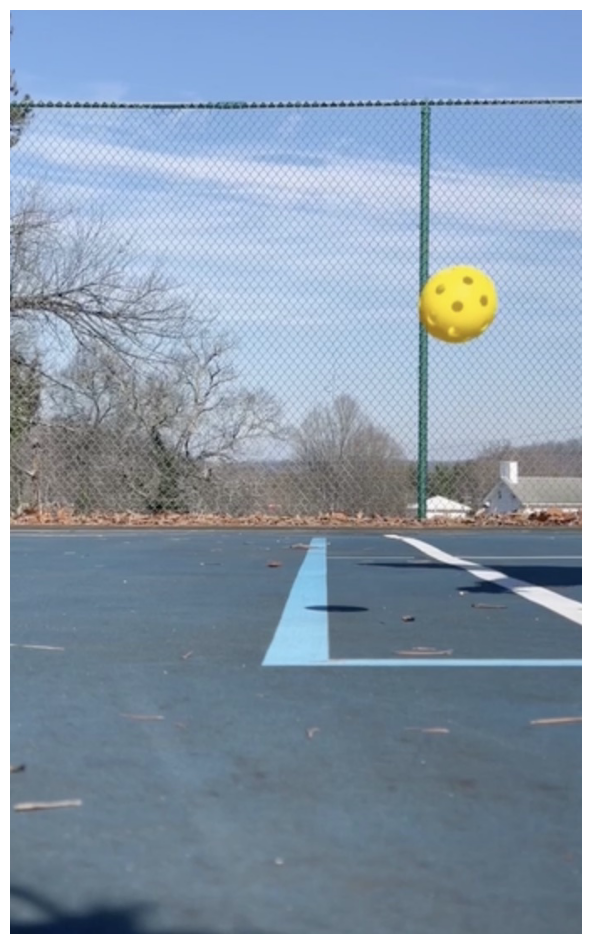

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/pbvids/1.jpeg"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

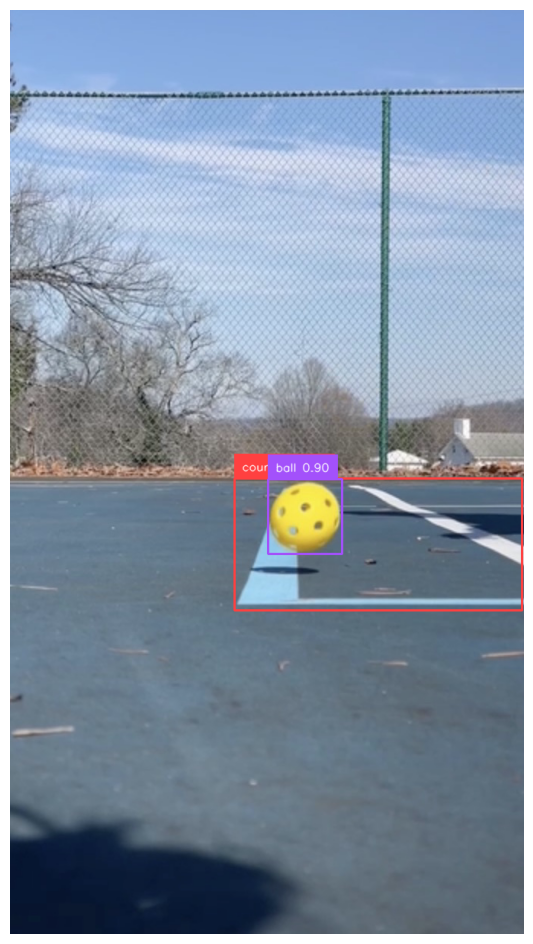

In [ ]:
# Define the path to the source video or image file.
# In this case, it's pointing to an image file (2.jpeg) stored in Google Drive.
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/pbvids/2.jpeg"

# Create annotators for drawing bounding boxes and labels on detected objects.
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Generate frames from the video or image.
# Since we're using an image, it will only return one frame.
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Get the first frame from the generator.
frame = next(frame_generator)

# Use the BALL_DETECTION_MODEL to detect objects in the frame.
# The `confidence=0.3` parameter means we only keep detections with at least 30% confidence.
result = BALL_DETECTION_MODEL.infer(frame, confidence=0.3)[0]

# Convert the inference result into a format that the Supervision library (sv) understands.
detections = sv.Detections.from_inference(result)

# Create labels for each detected object, showing its class name and confidence score.
labels = [
    f"{class_name} {confidence:.2f}"  # Format: "ObjectName ConfidenceScore"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

# Make a copy of the original frame to annotate it without modifying the original image.
annotated_frame = frame.copy()

# Draw bounding boxes around the detected objects.
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,  # The image to annotate
    detections=detections   # The detected objects
)

# Add labels to the annotated frame to indicate what each object is.
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,  # The image with bounding boxes
    detections=detections,  # The detected objects
    labels=labels           # The corresponding labels (object name & confidence)
)

# Display the annotated image with the detected objects.
sv.plot_image(annotated_frame)


# Find the courtline and detect when ball enters and draw line tracing trajectory


In [ ]:
# Import necessary libraries
import numpy as np  # For handling numerical operations
import cv2  # OpenCV for image and video processing
from collections import deque  # For storing ball movement history
import supervision as sv  # Supervision library for annotation and object tracking

# Define file paths
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/pbvids/60fps2balls.mov"  # Input video
ANNOTATED_VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/pbvids/newangletest.mov"  # Output annotated video

# Initialize annotators for visualization
#dot_annotator = sv.DotAnnotator()       # Draws dots at object positions
circle_annotator = sv.CircleAnnotator() # Draws circles around detected objects
box_annotator = sv.BoxAnnotator()       # Draws bounding boxes around objects

# Dictionary to store previous positions of detected balls for tracking
previous_centers = {}

# Define a class to represent a point (x, y)
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def as_xy_int_tuple(self):
        return (self.x, self.y)  # Return coordinates as a tuple (x, y)

# Define a class for colors in BGR format (Blue, Green, Red)
class Color:
    def __init__(self, b, g, r):
        self.b = b
        self.g = g
        self.r = r

    def as_bgr(self):
        return (self.b, self.g, self.r)  # Return color as a tuple (B, G, R)

# Define a function to process each frame of the video
def callback(frame: np.ndarray, _: int) -> np.ndarray:
    print(f'Processing frame: {_}')  # Print the current frame index

    # Detect objects in the current frame using the BALL_DETECTION_MODEL
    result = BALL_DETECTION_MODEL.infer(frame, confidence=0.2)[0]
    detections = sv.Detections.from_inference(result)  # Convert results to supervision format

    # Separate detections by object type
    courtline_detections = detections[detections.class_id == 1]  # Court lines
    ball_detections = detections[detections.class_id == 0]  # Pickleballs

    # Draw courtline bounding box if detected
    if courtline_detections.xyxy.shape[0] > 0:
        x1, y1, x2, y2 = courtline_detections.xyxy[0].astype(int)  # Get courtline bounding box
        cv2.rectangle(frame, (x1, y1), (x2, y2), Color(0, 255, 0).as_bgr(), 2)  # Draw green rectangle

    # Process each detected pickleball
    for i in range(ball_detections.xyxy.shape[0]):
        # Get ball bounding box and compute its center
        x1, y1, x2, y2 = ball_detections.xyxy[i].astype(int)
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        # Assign an ID to the detected ball (if tracking IDs exist)
        object_id = ball_detections.data['id'][i] if 'id' in ball_detections.data else i

        # Initialize tracking for the ball if it's detected for the first time
        if object_id not in previous_centers:
            previous_centers[object_id] = deque(maxlen=10)  # Store last 10 positions

        # Add current position to tracking history
        previous_centers[object_id].append((center_x, center_y))

        # Check if the ball is inside the courtline bounding box
        inside_zone = (x1 <= center_x <= x2 and y1 <= center_y <= y2)

        # Draw a circular bounding box around the ball
        ball_center = Point(center_x, center_y)
        frame = circle_annotator.annotate(frame.copy(), detections=ball_detections)

        # Draw ball trajectory (trailing line) only if the ball is inside the court
        if inside_zone and len(previous_centers[object_id]) > 1:
            points = list(previous_centers[object_id])  # Get stored positions
            for j in range(len(points) - 1):
                start_point = Point(points[j][0], points[j][1])
                end_point = Point(points[j + 1][0], points[j + 1][1])
                line_color = Color(0, 0, 255)  # Blue color for trajectory
                frame = sv.draw_line(frame, start_point, end_point, line_color, thickness=3)  # Draw the line

    return frame  # Return the processed frame

# Process the video frame-by-frame and save the annotated output
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,   # Input video file
    target_path=ANNOTATED_VIDEO_PATH,  # Output video file
    callback=callback  # Function to apply to each frame
)



Processing frame: 0
Processing frame: 1
Processing frame: 2
Processing frame: 3
Processing frame: 4
Processing frame: 5
Processing frame: 6
Processing frame: 7
Processing frame: 8
Processing frame: 9
Processing frame: 10
Processing frame: 11
Processing frame: 12
Processing frame: 13
Processing frame: 14
Processing frame: 15
Processing frame: 16
Processing frame: 17
Processing frame: 18
Processing frame: 19
Processing frame: 20
Processing frame: 21
Processing frame: 22
Processing frame: 23
Processing frame: 24
Processing frame: 25
Processing frame: 26
Processing frame: 27
Processing frame: 28
Processing frame: 29
Processing frame: 30
Processing frame: 31
Processing frame: 32
Processing frame: 33
Processing frame: 34
Processing frame: 35
Processing frame: 36
Processing frame: 37
Processing frame: 38
Processing frame: 39
Processing frame: 40
Processing frame: 41
Processing frame: 42
Processing frame: 43
Processing frame: 44
Processing frame: 45
Processing frame: 46
Processing frame: 47
Pr

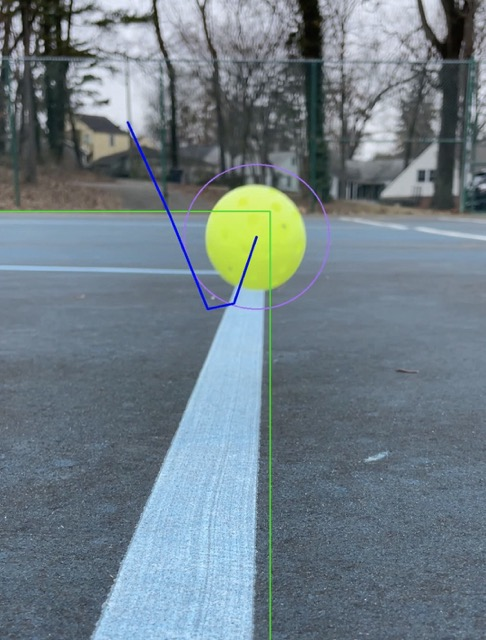

# Create a mask trailing ball effect


In [ ]:
import numpy as np
import cv2
import supervision as sv
from collections import deque

# Global dictionary to store last 10 ball masks for each object
previous_masks = {}

# Circle annotator for the current ball detection
circle_annotator = sv.CircleAnnotator()

def create_ball_mask(frame, center, radius=70):
    """Create a mask for the ball, given its center and radius"""
    mask = np.zeros_like(frame)
    cv2.circle(mask, center, radius, (255, 255, 255), -1)  # Draw a filled white circle
    return mask

def callback(frame: np.ndarray, frame_number: int) -> np.ndarray:
    print(f'Processing frame: {frame_number}')

    # Get detections from the BALL_DETECTION_MODEL (replace this with your actual model)
    result = BALL_DETECTION_MODEL.infer(frame, confidence=0.2)[0]
    detections = sv.Detections.from_inference(result)

    # Check if there are detections
    if detections.xyxy.shape[0] > 0:
        for i in range(detections.xyxy.shape[0]):
            # Get the coordinates of the detected object
            x1, y1, x2, y2 = detections.xyxy[i].astype(int)
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2

            # Get the object ID (for handling multiple objects)
            object_id = detections.data['id'][i] if 'id' in detections.data else i

            # If this is the first frame, initialize the deque to store last 10 points for this object
            if object_id not in previous_masks:
                previous_masks[object_id] = deque(maxlen=10)

            # Create a mask for the current frame's detected ball
            current_mask = create_ball_mask(frame, (center_x, center_y), radius=110)
            previous_masks[object_id].append(current_mask)

            # If there are at least 2 masks, blend the last 10 frames' masks with alpha transparency
            result_mask = np.zeros_like(frame)
            alpha = 0.25  # Set transparency level (adjust this for the desired effect)
            for mask in reversed(previous_masks[object_id]):  # Reversed to blend from oldest to newest
                result_mask = cv2.addWeighted(result_mask, 1 - alpha, mask, alpha, 0)

            # Overlay the blended ball masks on the original frame
            frame_with_trail = cv2.addWeighted(frame, 1, result_mask, 0.4, 0)

            # Annotate the frame with a circle representing the current ball's position
            frame_with_trail = circle_annotator.annotate(frame_with_trail, detections=detections)

        return frame_with_trail

    return frame

# Example of how the video processing will work
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path="/content/drive/MyDrive/Colab Notebooks/pbvids/faded3.mov",
    callback=callback
)


Processing frame: 0
Processing frame: 1
Processing frame: 2
Processing frame: 3
Processing frame: 4
Processing frame: 5
Processing frame: 6
Processing frame: 7
Processing frame: 8
Processing frame: 9
Processing frame: 10
Processing frame: 11
Processing frame: 12
Processing frame: 13
Processing frame: 14
Processing frame: 15
Processing frame: 16
Processing frame: 17
Processing frame: 18
Processing frame: 19
Processing frame: 20
Processing frame: 21
Processing frame: 22
Processing frame: 23
Processing frame: 24
Processing frame: 25
Processing frame: 26
Processing frame: 27
Processing frame: 28
Processing frame: 29
Processing frame: 30
Processing frame: 31
Processing frame: 32
Processing frame: 33
Processing frame: 34
Processing frame: 35
Processing frame: 36
Processing frame: 37
Processing frame: 38
Processing frame: 39
Processing frame: 40
Processing frame: 41
Processing frame: 42
Processing frame: 43
Processing frame: 44
Processing frame: 45
Processing frame: 46
Processing frame: 47
Pr

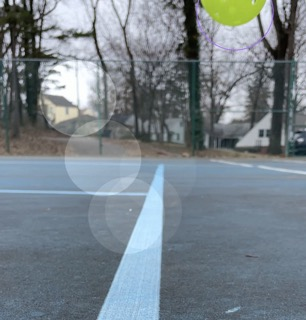

In [ ]:
import numpy as np
import cv2
import supervision as sv
from collections import deque

# Global dictionary to store last 10 pickleball images for each object
previous_balls = {}

def extract_ball_image(frame, center, radius=100):
    """Extract the ball image (cropped region) from the frame."""
    x, y = center
    # Define the bounding box around the ball
    x1 = max(x - radius, 0)
    y1 = max(y - radius, 0)
    x2 = min(x + radius, frame.shape[1])
    y2 = min(y + radius, frame.shape[0])

    # Crop the ball region from the frame
    ball_image = frame[y1:y2, x1:x2]

    return ball_image, (x1, y1, x2, y2)  # Return ball image and its bounding box

def callback(frame: np.ndarray, frame_number: int) -> np.ndarray:
    print(f'Processing frame: {frame_number}')

    # Get detections from the BALL_DETECTION_MODEL (replace this with your actual model)
    result = BALL_DETECTION_MODEL.infer(frame, confidence=0.2)[0]
    detections = sv.Detections.from_inference(result)

    # Check if there are detections
    if detections.xyxy.shape[0] > 0:
        for i in range(detections.xyxy.shape[0]):
            # Get the coordinates of the detected object
            x1, y1, x2, y2 = detections.xyxy[i].astype(int)
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2

            # Get the object ID (for handling multiple objects)
            object_id = detections.data['id'][i] if 'id' in detections.data else i

            # If this is the first frame, initialize the deque to store last 10 balls for this object
            if object_id not in previous_balls:
                previous_balls[object_id] = deque(maxlen=10)

            # Extract the ball image from the frame
            ball_image, _ = extract_ball_image(frame, (center_x, center_y), radius=100)

            # Append the current ball image to the deque
            previous_balls[object_id].append(ball_image)

            # If there are at least 2 ball images, blend the last 10 frames' ball images with alpha transparency
            result_frame = frame.copy()
            alpha = 0.2  # Set transparency level (adjust this for the desired effect)

            for ball in reversed(previous_balls[object_id]):  # Reversed to blend from oldest to newest
                # Resize the ball image if needed (ensure it's not too big or small)
                resized_ball = cv2.resize(ball, (100, 100))  # Resize to match the radius or desired size

                # Find the center of the current frame to position the ball image
                top_left = (center_x - resized_ball.shape[1] // 2, center_y - resized_ball.shape[0] // 2)
                bottom_right = (center_x + resized_ball.shape[1] // 2, center_y + resized_ball.shape[0] // 2)

                # Ensure the placement is within the frame boundaries
                top_left = (max(top_left[0], 0), max(top_left[1], 0))
                bottom_right = (min(bottom_right[0], frame.shape[1]), min(bottom_right[1], frame.shape[0]))

                # Overlay the resized ball image on the frame with alpha blending
                ball_region = frame[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
                if ball_region.shape == resized_ball.shape:
                    result_frame[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = cv2.addWeighted(
                        ball_region, 1 - alpha, resized_ball, alpha, 0
                    )

            # Annotate the frame with a circle representing the current ball's position (optional)
            frame_with_ball = circle_annotator.annotate(result_frame, detections=detections)

        return frame_with_ball

    return frame

# Example of how the video processing will work
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path="/content/drive/MyDrive/Colab Notebooks/pbvids/alpha.mov",
    callback=callback
)


Processing frame: 0
Processing frame: 1
Processing frame: 2
Processing frame: 3
Processing frame: 4
Processing frame: 5
Processing frame: 6
Processing frame: 7
Processing frame: 8
Processing frame: 9
Processing frame: 10
Processing frame: 11
Processing frame: 12
Processing frame: 13
Processing frame: 14
Processing frame: 15
Processing frame: 16
Processing frame: 17
Processing frame: 18
Processing frame: 19
Processing frame: 20
Processing frame: 21
Processing frame: 22
Processing frame: 23
Processing frame: 24
Processing frame: 25
Processing frame: 26
Processing frame: 27
Processing frame: 28
Processing frame: 29
Processing frame: 30
Processing frame: 31
Processing frame: 32
Processing frame: 33
Processing frame: 34
Processing frame: 35
Processing frame: 36
Processing frame: 37
Processing frame: 38
Processing frame: 39
Processing frame: 40
Processing frame: 41
Processing frame: 42
Processing frame: 43
Processing frame: 44
Processing frame: 45
Processing frame: 46
Processing frame: 47
Pr

# Court line boundary detection using Hough Lines

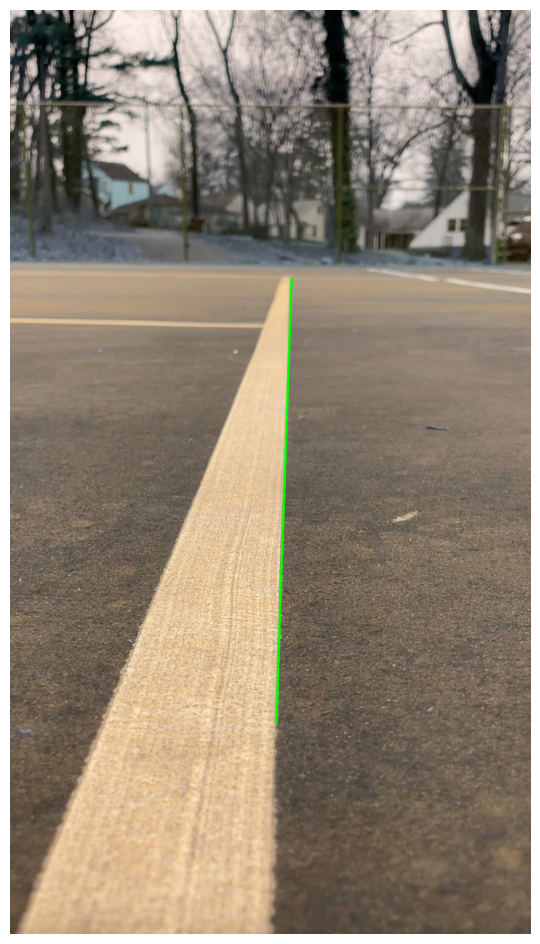

True

In [ ]:
# Import necessary libraries
import cv2  # OpenCV for image processing
import numpy as np  # NumPy for numerical operations
import supervision as sv  # Supervision for visualizing images

# Define paths for input and output images
output_path = '/content/drive/MyDrive/Colab Notebooks/pbvids/linesDetected2.jpg'  # Path to save the processed image
image_path = '/content/drive/MyDrive/Colab Notebooks/pbvids/4.jpeg'  # Path of the input image

# Load the image from the specified path
image = cv2.imread(image_path)

# Convert the image from BGR (OpenCV default) to RGB (for correct color display)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale for edge detection (removes color information)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to smooth the image and reduce noise
# The (5, 5) kernel size determines the level of blurring
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Use Canny edge detection to find edges in the image
# The thresholds (30, 140) determine which gradients are considered edges
edges = cv2.Canny(blurred, 30, 140)

# Use the Hough Line Transform to detect straight lines in the edge-detected image
# Parameters:
# - 1: Distance resolution of the accumulator in pixels
# - np.pi/180: Angular resolution in radians
# - threshold=150: Minimum number of votes needed to be considered a line
# - minLineLength=50: Minimum length of a line to be detected
# - maxLineGap=10: Maximum gap between line segments to be treated as a single line
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=150, minLineLength=50, maxLineGap=10)

# Create a copy of the original image to draw the detected lines
output_image = image.copy()

# Initialize variables to store the top and bottom points of the detected line
top_point = None
bottom_point = None

# If lines are detected, process each one to find the most extreme (top and bottom) points
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]  # Extract line coordinates

        # Filter out only vertical lines (lines where the height difference is greater than width)
        if abs(y2 - y1) > abs(x2 - x1):  # Detects vertical lines

            # Focus on vertical lines located on the right half of the image
            if x1 > image.shape[1] // 2:

                # Find the highest point of the detected line
                if top_point is None or y1 < top_point[1]:
                    top_point = (x1, y1) if y1 < y2 else (x2, y2)

                # Find the lowest point of the detected line
                if bottom_point is None or y1 > bottom_point[1]:
                    bottom_point = (x1, y1) if y1 > y2 else (x2, y2)

# If both top and bottom points are found, draw a continuous vertical line
if top_point and bottom_point:
    cv2.line(output_image, top_point, bottom_point, (0, 255, 0), 3)  # Green line with thickness 3

# Convert the processed image to RGB and display it
sv.plot_image(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

# Save the annotated image with the detected line to the specified output path
cv2.imwrite(output_path, output_image)
